# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

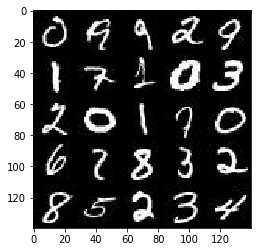

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

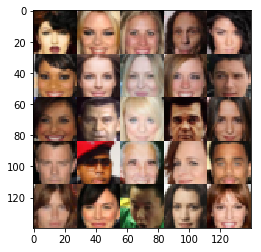

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [27]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

In [91]:
def discriminator(images, reuse=False, keep_prob=0.9):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        dp2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(dp2, training=True)
        relu2 = leaky_relu(bn2)
        #7x7x64
        
        #x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding="same")
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(alpha*bn3, bn3)
        #4x4X128
        
        #Flatten it
        relu_shape = int(relu2.shape[1]*relu2.shape[2]*relu2.shape[3])
        flat = tf.reshape(relu2, (-1, relu_shape))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*256)
        #Reshape it to start the convolutional stack, 2x2x256
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leaky_relu(bn1)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding="valid")
        dp2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(dp2, training=is_train)
        relu2 = leaky_relu(bn2)
        
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(bn3)
        #print(x3.shape)
        
        # Output layer, 32x32x?
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding="same")
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [86]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [78]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 128 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.9077... Generator Loss: 0.4306
Epoch 1/2... Discriminator Loss: 1.7141... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 1.7002
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.4031
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.5610
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.3826
Epoch 1/2... Discriminator Loss: 0.6249... Generator Loss: 1.9458
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.8953
Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 1.2404
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.4665


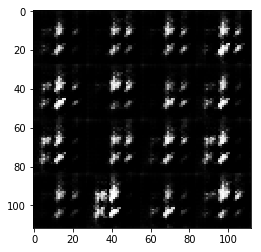

Epoch 1/2... Discriminator Loss: 0.6973... Generator Loss: 1.7897
Epoch 1/2... Discriminator Loss: 0.6409... Generator Loss: 2.1455
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 2.0907
Epoch 1/2... Discriminator Loss: 0.6406... Generator Loss: 2.0882
Epoch 1/2... Discriminator Loss: 0.7073... Generator Loss: 2.7211
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 2.1465
Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 2.1735
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 1.5930
Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 2.5826
Epoch 1/2... Discriminator Loss: 0.8155... Generator Loss: 1.6404
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.6589


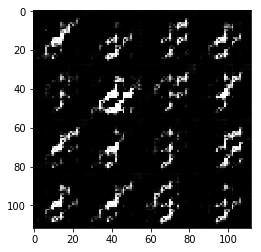

Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.2557
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.3950
Epoch 1/2... Discriminator Loss: 0.7633... Generator Loss: 1.8915
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.7501
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 2.3809
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.8688
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 1.8445
Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.6892
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 2.0916
Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.8486
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.8245
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 1.2645


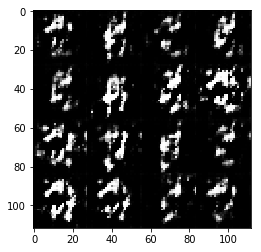

Epoch 1/2... Discriminator Loss: 2.2145... Generator Loss: 0.4452
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.0940
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.7878
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 2.6930
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 1.3777
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.1909
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 1.6111
Epoch 1/2... Discriminator Loss: 0.8982... Generator Loss: 1.8172
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 2.3228
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.4794
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 2.3557


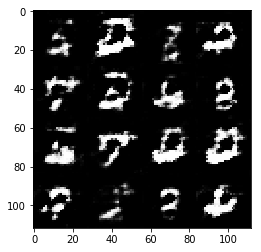

Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 1.2836
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 1.3979
Epoch 1/2... Discriminator Loss: 0.7667... Generator Loss: 2.3679
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 2.2451
Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 1.5743
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 2.8921
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.3294
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.4833
Epoch 1/2... Discriminator Loss: 0.7767... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.8907
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 2.2180
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 2.2060


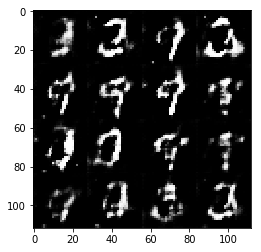

Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 1.7591
Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 2.2946
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 1.5367
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.1543
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 2.3106
Epoch 1/2... Discriminator Loss: 1.0749... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 1.2304
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 2.0464
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.4715
Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 1.9016
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 2.2027


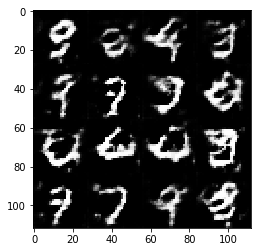

Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 2.2485
Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 2.3527
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.3674
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 2.3410
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.7702
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.4094
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.8439
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 1.3890
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.3538
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 1.9592


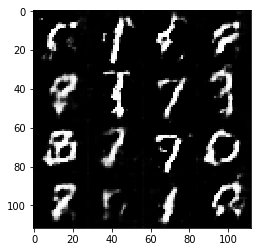

Epoch 1/2... Discriminator Loss: 0.8747... Generator Loss: 1.4599
Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 1.7660
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.7607
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 1.6899
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.0788
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.6009
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 1.7370
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.5666
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 1.6048
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.6693
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.7766
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.3725


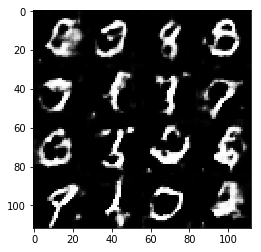

Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.4579
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.9068
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 1.4039
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.3154
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 1.5868
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.7429
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 1.7455
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 1.1461
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.8075


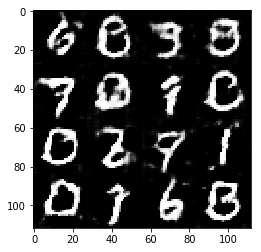

Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 1.7448
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 1.5280
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.1010
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 1.0906
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.9237
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.1826
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 1.5866
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.5014
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.9454
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 1.2619


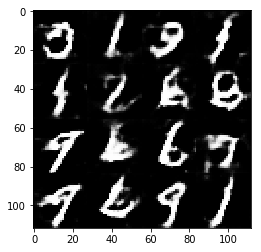

Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 1.4985
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 1.4183
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 1.2044
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 1.6797
Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 1.4829
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 0.9970... Generator Loss: 1.2804
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 1.1570
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 1.5826
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.5363


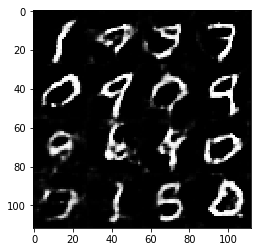

Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.3713
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 1.2248
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 1.3734
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 1.0099
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 1.0179
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 1.3716


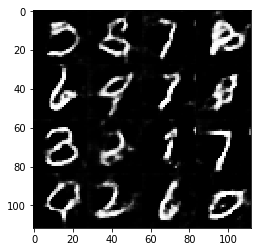

Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 1.4965
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.9624
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 1.7955
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 1.0343
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 1.3619
Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 1.5126
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.6113
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 2.3540
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 1.0967
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 0.9704


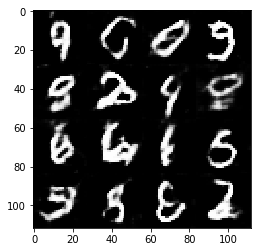

Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 1.3686
Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 1.5835
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.8784
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 1.6640
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.2522
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 2.3084
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.2077
Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 1.2505
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.1629
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.3128
Epoch 2/2... Discriminator Loss: 1.4280... Generator Loss: 0.7198


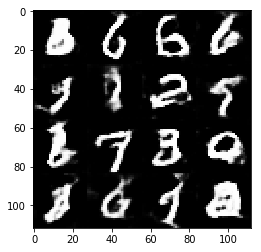

Epoch 2/2... Discriminator Loss: 1.6225... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.7597
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 2.1994
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.4044
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 1.3100


In [87]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7679... Generator Loss: 0.2260
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.2228
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 2.4408
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 2.1422
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 2.5257
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 2.2343... Generator Loss: 7.1504
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 2.3794


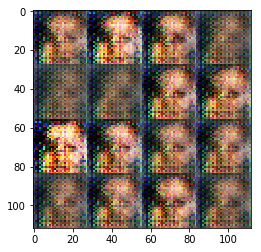

Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.9301
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.9178
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.8008
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.4240
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.9420


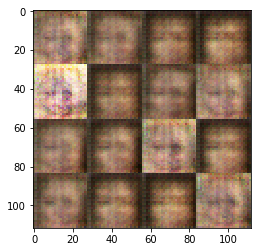

Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.3223
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.5306


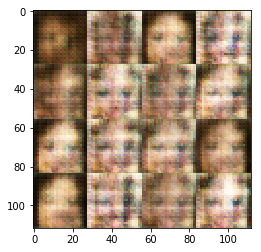

Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.8090... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.1711


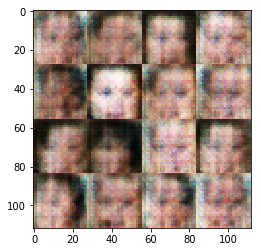

Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.7646... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.8723... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.0448


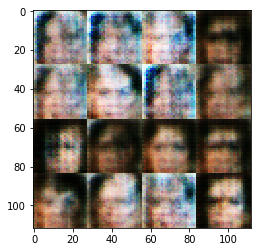

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.8649... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 1.3135
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.0283


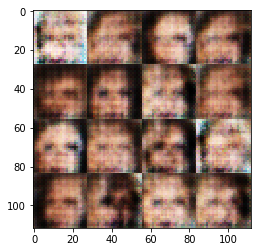

Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.6380


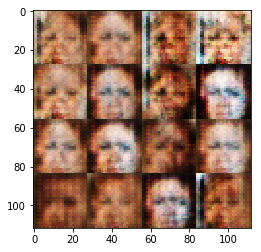

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.7254
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.3235


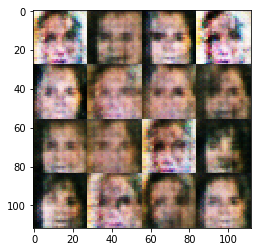

Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.6854... Generator Loss: 2.5724
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.1973


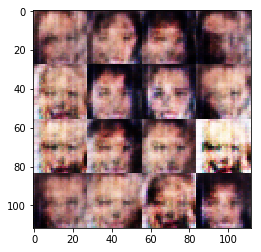

Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 1.9609


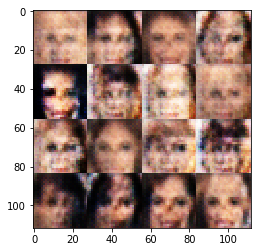

Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.0273


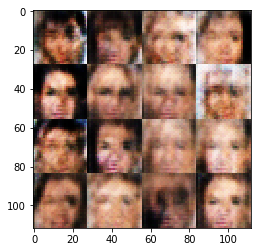

Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.3193
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 1.1233


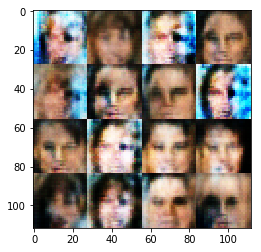

Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.9312... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.8718


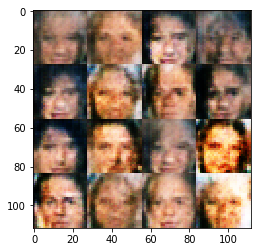

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8407


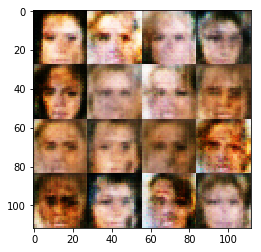

Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 1.3540
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.0129


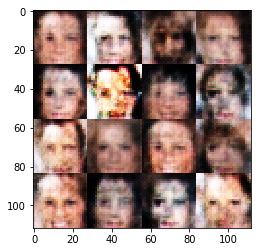

Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8999


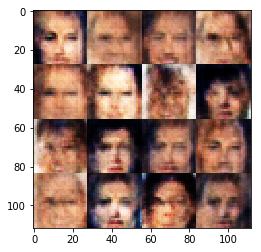

Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.9584


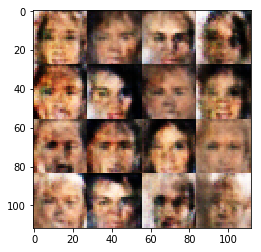

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 1.1574


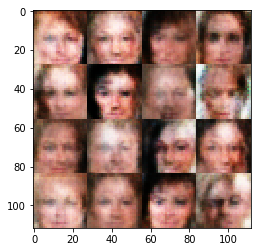

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 1.0188


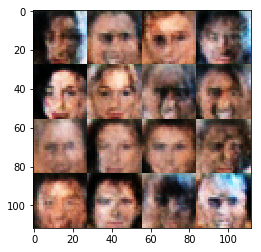

Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.3676
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.5616


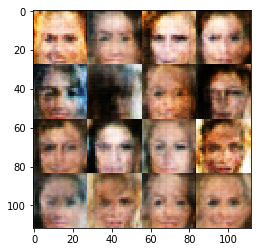

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.2684
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.3152
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8125


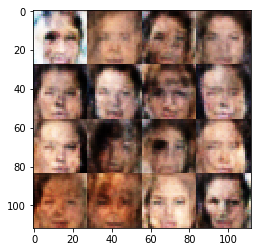

Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.3501
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9154


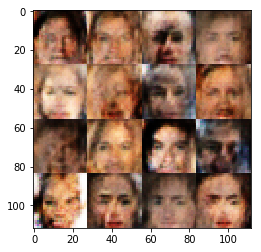

Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.1116


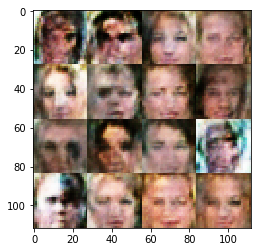

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8930


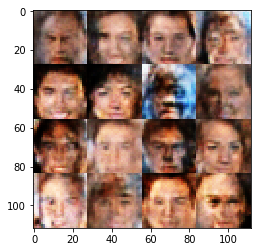

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.1644


In [92]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.